<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/AnaCRV_INP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install kerberos

In [102]:
!apt-get -qq install krb5-user

In [103]:
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf

--2021-07-01 05:58:02--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.02s   

2021-07-01 05:58:03 (770 KB/s) - ‘krb5.conf’ saved [17486/17486]



In [104]:
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'

#Copy files from FNAL

In [ ]:
!kinit oksuzian@FNAL.GOV

Password for oksuzian@FNAL.GOV: 


In [ ]:
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.owner.trkana-reco.version.sequencer.cry4v940loreco17000_v1.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/ana.amirkhan.RecoMC.cry4v940hireco17000_v1.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/ana.dzhadan.RecoMC.7000.root .

In [ ]:
!cp ana.*.root drive/MyDrive/root_files_oksuzian/

#Init

In [1]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Mounted at /content/drive


In [2]:
%pip install -q scikit-hep
from skhep.visual import MplPlotter as skh_plt

     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 225kB 32.5MB/s 
     |████████████████████████████████| 8.1MB 29.1MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 245kB 35.9MB/s 
     |████████████████████████████████| 163kB 55.0MB/s 
     |████████████████████████████████| 1.9MB 41.8MB/s 
     |████████████████████████████████| 327kB 40.4MB/s 
     |████████████████████████████████| 215kB 40.8MB/s 
     |████████████████████████████████| 40kB 5.1MB/s 
     |████████████████████████████████| 122kB 47.8MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 122kB 41.1MB/s 
     |████████████████████████████████| 5.4MB 22.1MB/s 
     |████████████████████████████████| 491kB 41.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61

In [3]:
%pip install uproot3

In [4]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [5]:
import uproot3
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plotly import graph_objs as go
import pylab
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Keras libs
import keras
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation
from keras.layers import BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import Adam
import keras.backend as k

import math
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import brier_score_loss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix

#Load dataframes

In [6]:
fileH = uproot3.open("drive/MyDrive/root_files_oksuzian/ana.amirkhan.RecoMC.cry4v940hireco17000_v1.root")
fileL = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.owner.trkana-reco.version.sequencer.cry4v940loreco17000_v1.root")
trkanaH = fileH["TrkAnaNeg"]["trkana"]
trkanaL = fileL["TrkAnaNeg"]["trkana"]


In [7]:
dfL_eve = trkanaL.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*', '_*'], flatname=default_flatname, flatten=True)
dfL_crv = trkanaL.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfH_eve = trkanaH.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*', '_*'], flatname=default_flatname, flatten=True)
dfH_crv = trkanaH.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfL_crv = dfL_crv[dfL_crv.index.get_level_values('subentry') == dfL_crv["bestcrv"]]
dfH_crv = dfH_crv[dfH_crv.index.get_level_values('subentry') == dfH_crv["bestcrv"]]

pd.merge(dfL_eve, dfL_crv, how="left", on='entry')
dfL = dfL_eve.merge(dfL_crv, how="left", on="entry")
dfH = dfH_eve.merge(dfH_crv, how="left", on="entry")

dfH['is_high'] = 1
dfL['is_high'] = 0

df = pd.concat([dfH, dfL], axis=0)
df["crvinfo__dT"] = df["crvinfo__timeWindowStart"] - df["de_t0"]
df['deent_d0_om'] = df["deent_d0"]+2.0/df["deent_om"]
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0

df = df.fillna(-999999)

#Define cuts

In [8]:
#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > 100)",
    "(deent_mom < 110)"
]
cut_extmom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]
cut_lbox = " & ".join(cuts)

crv_time = "((-de_t0 + crvinfo__timeWindowStart) > 50 | (de_t0-crvinfo__timeWindowStart) > 150.0)"



In [9]:
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

In [57]:
df_cut_nomom = df.query(cut_nomom)
df_cut_extmom = df.query(cut_extmom)
df_cut_loose = df.query(cut_loose)
df_time = df.query(crv_time + " & " + cut_nomom)

df = df.query(cut_pid_trkqual_ue)
#df = df.query(cut_extmom)

#Make plots

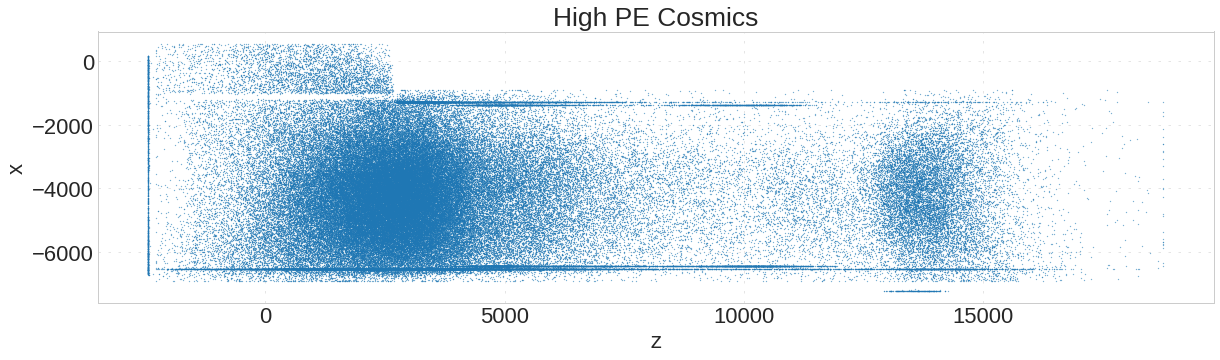

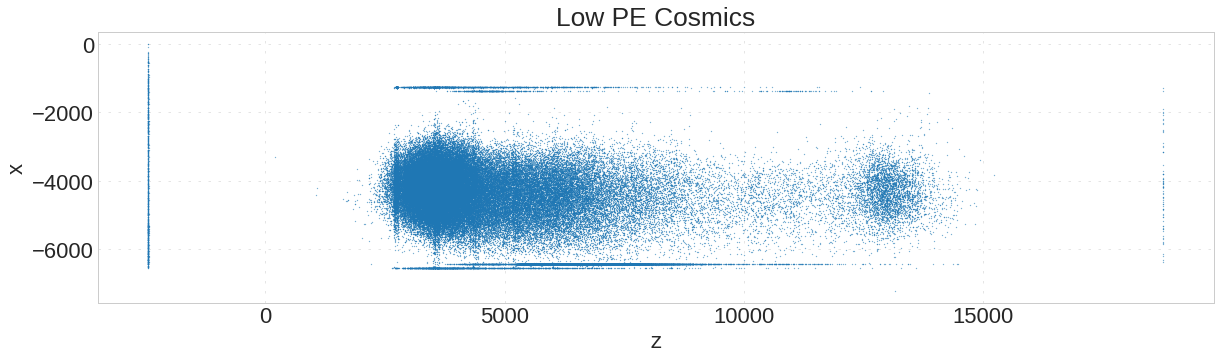

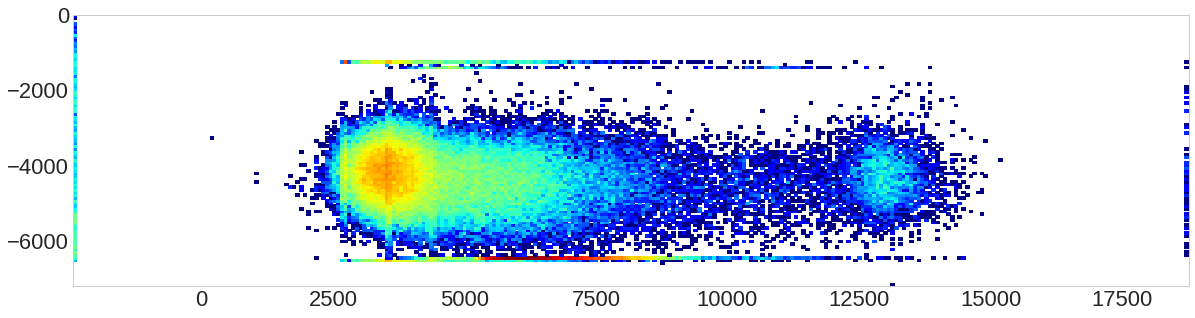

In [58]:
import matplotlib as mpl

plt.plot(df.query('is_high == 1 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 1 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=0.5);
plt.title("High PE Cosmics");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.plot(df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=0.5);
plt.title("Low PE Cosmics");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.hist2d(df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__x'], bins=(300, 100), norm=mpl.colors.LogNorm(), cmap = plt.cm.jet);


In [59]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [60]:
MU2E_LIVETIME = 1E7
LO_LIVETIME = 5.14E7
HI_LIVETIME = 5.49E6

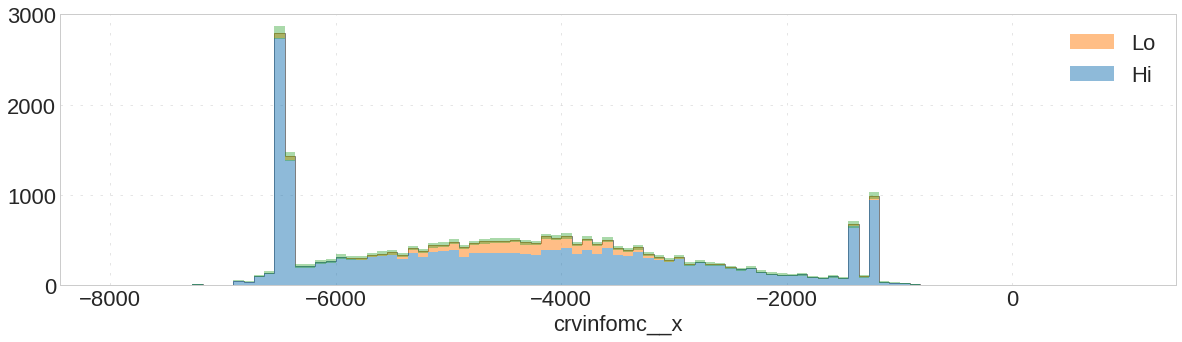

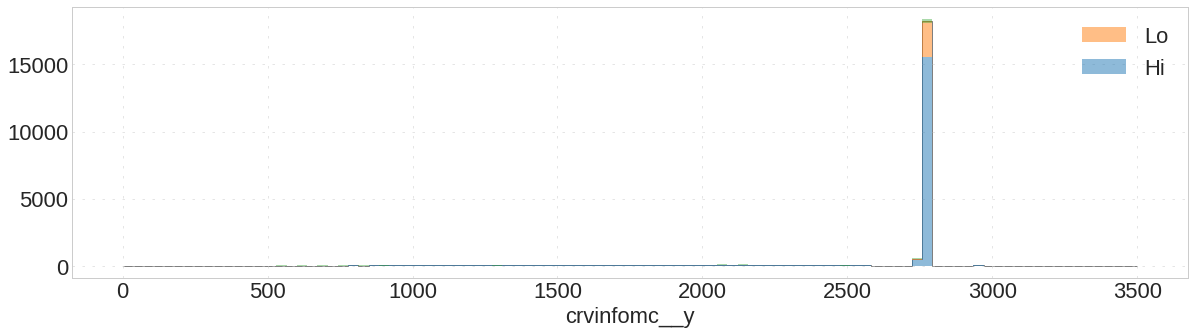

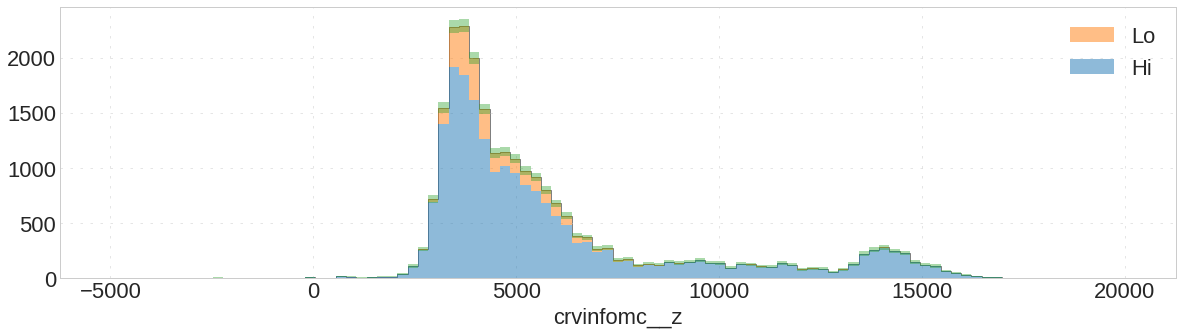

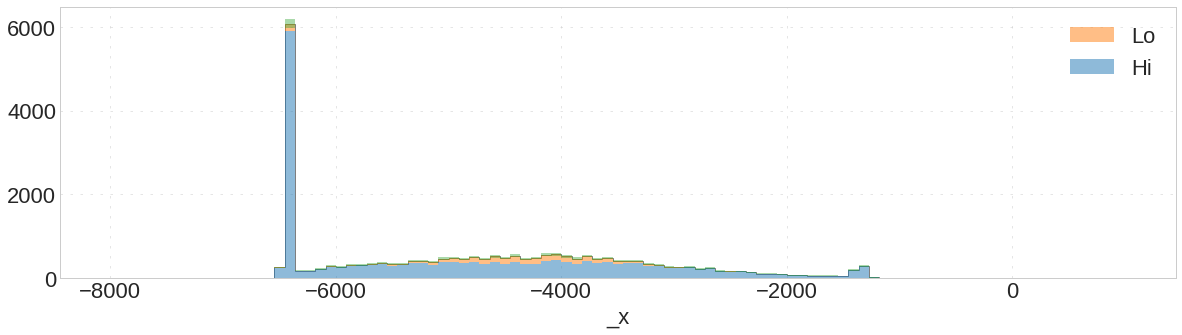

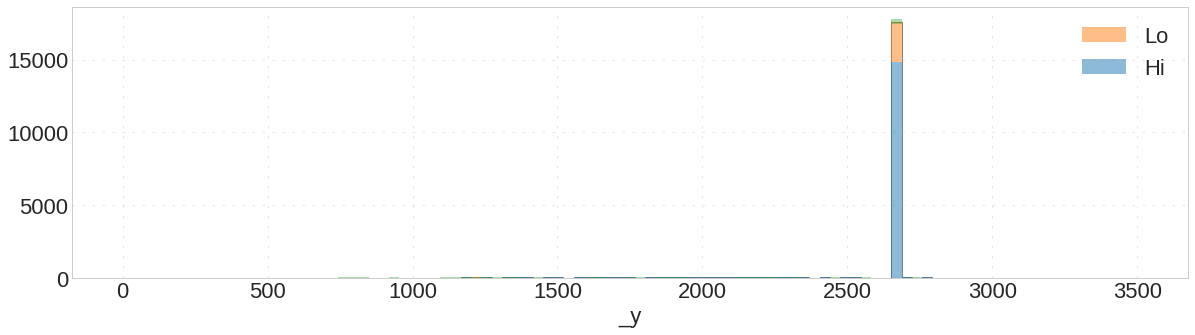

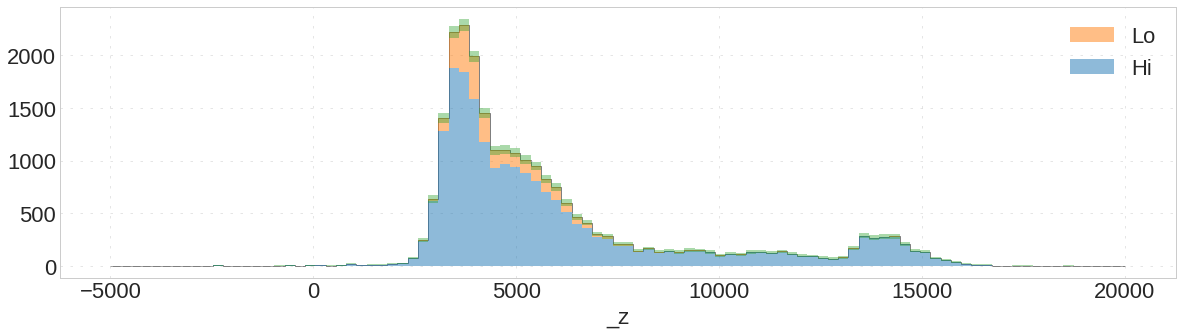

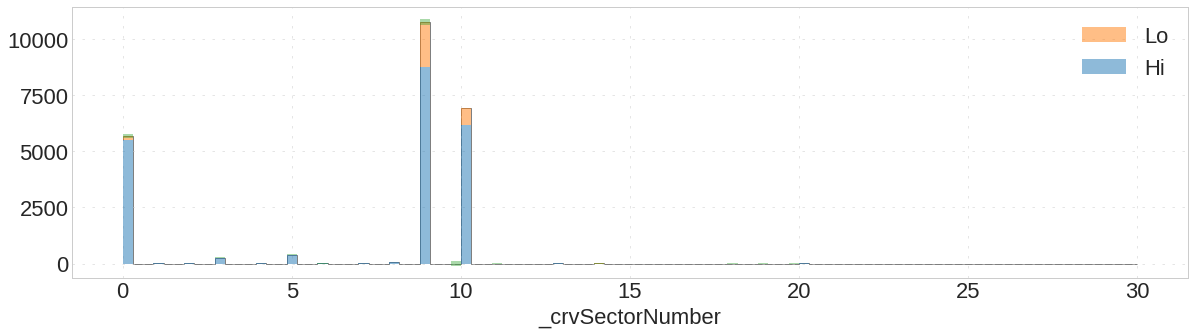

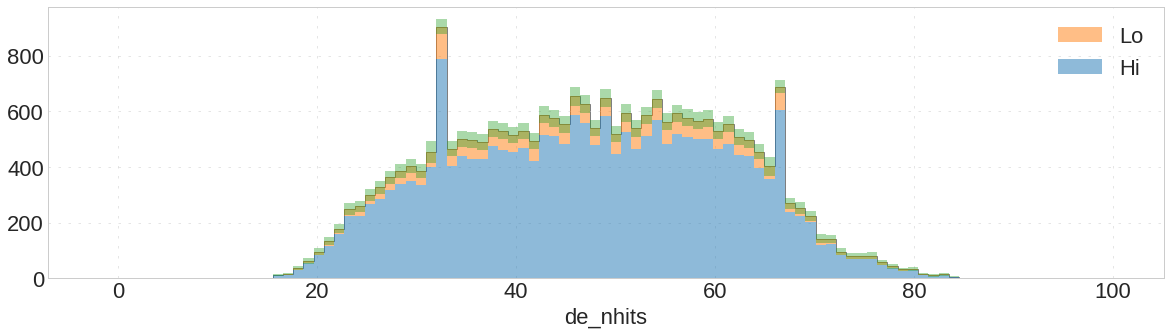

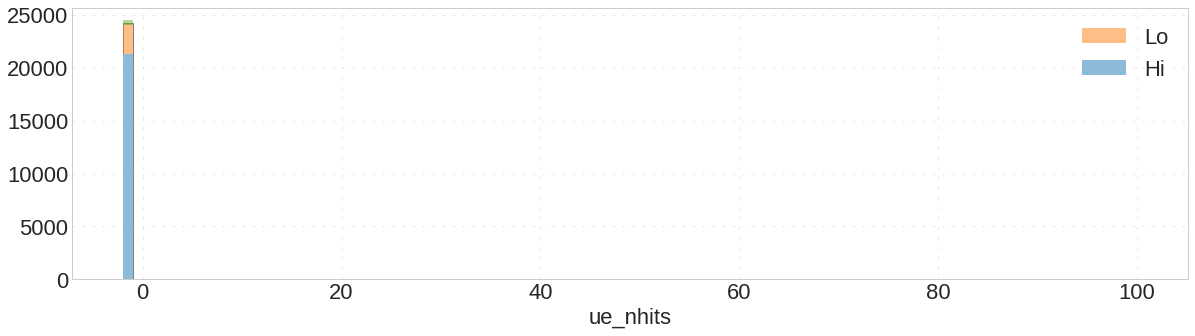

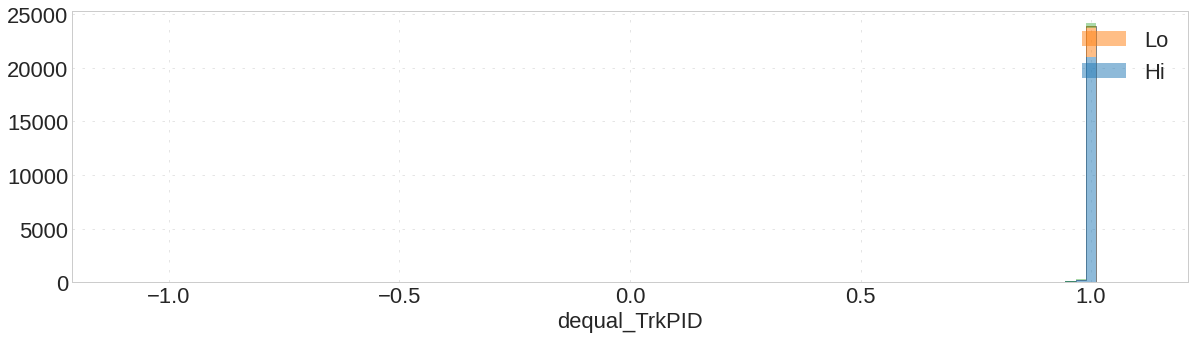

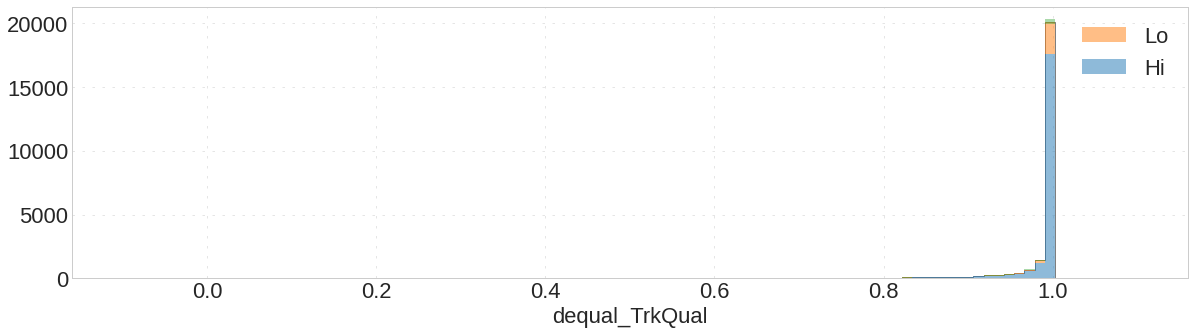

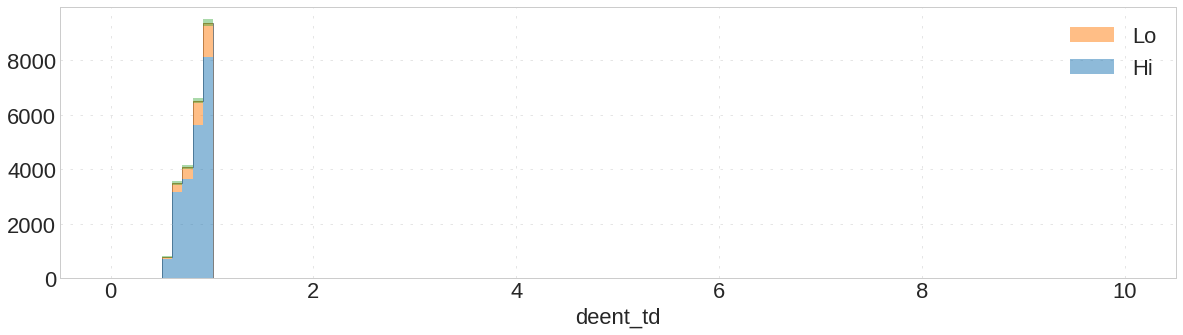

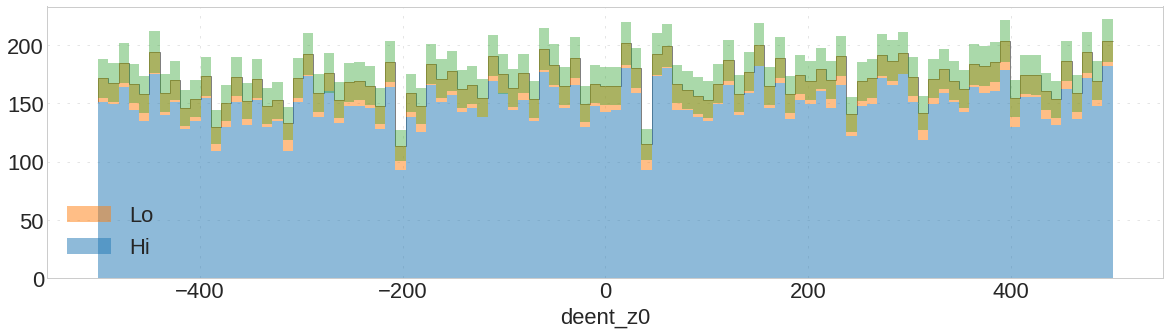

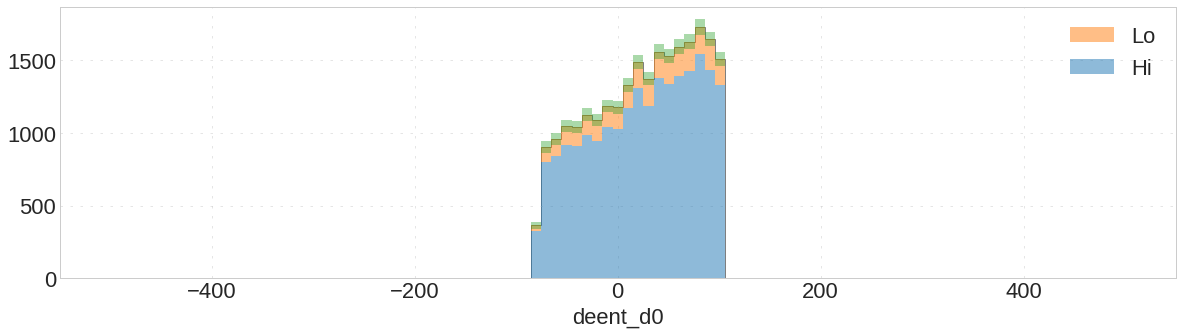

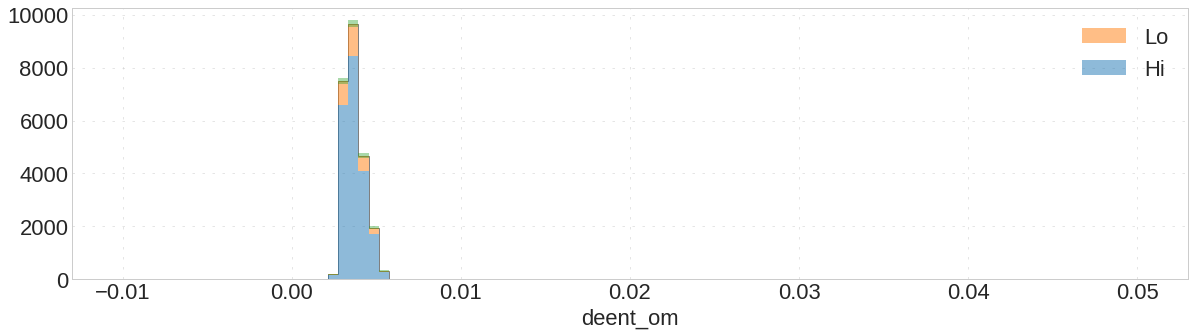

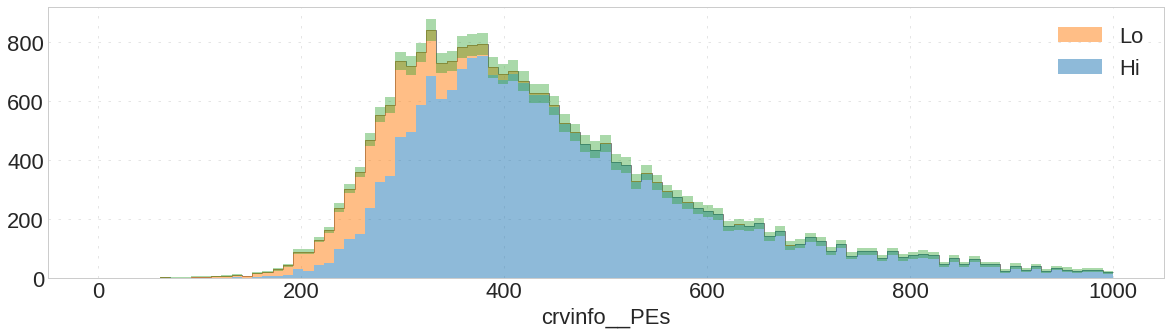

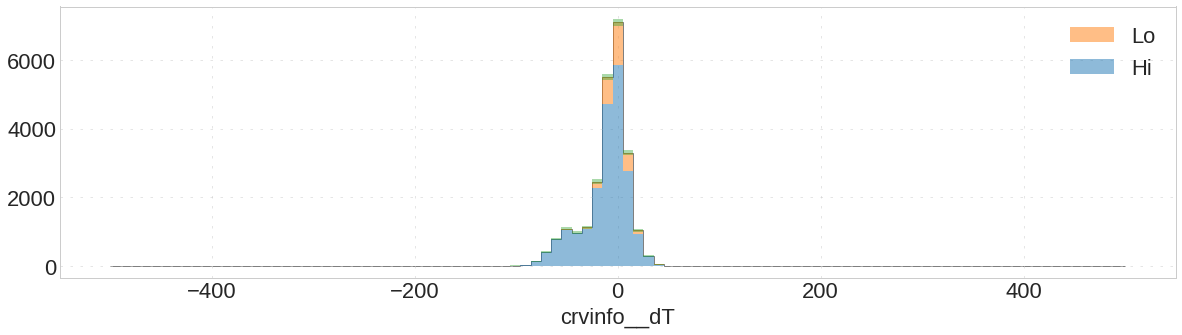

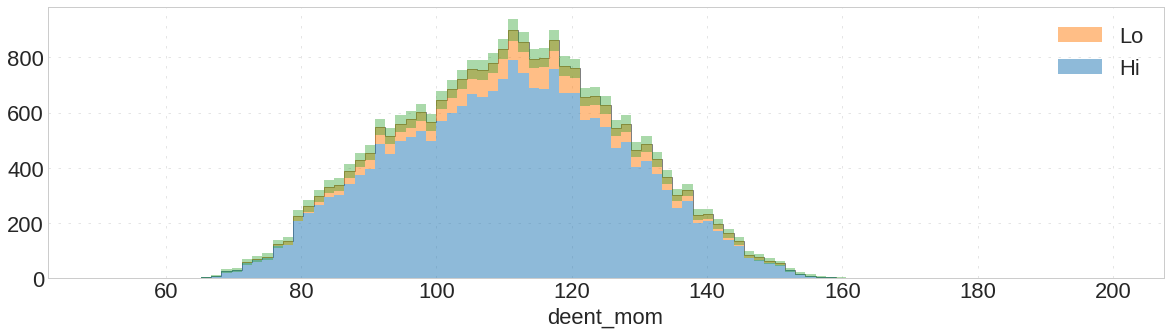

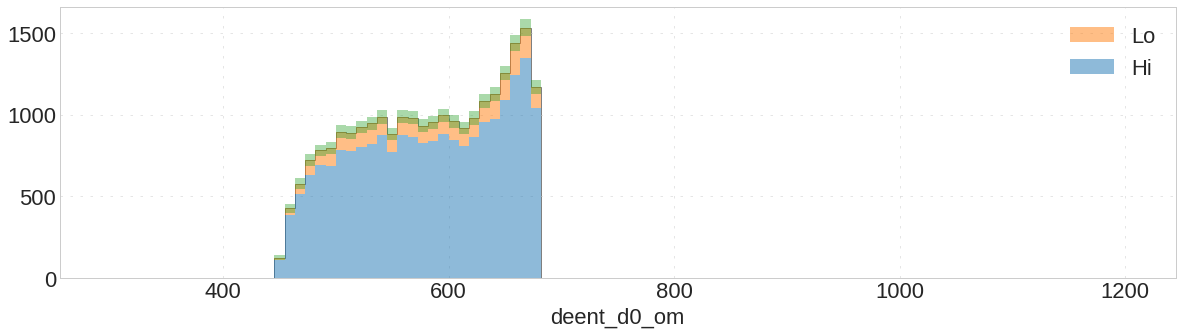

<Figure size 1440x360 with 0 Axes>

In [61]:
variables_list = {'crvinfomc__x': [-8000, 1000], 
                  'crvinfomc__y': [0, 3500],
                  'crvinfomc__z': [-5000, 20000],

                  '_x': [-8000, 1000], 
                  '_y': [0, 3500],
                  '_z': [-5000, 20000],
                  '_crvSectorNumber': [0, 30],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__PEs': [0, 1000],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

for var in variables_list:
  xmin = variables_list[var][0]
  xmax = variables_list[var][1]
  yhi = df.query('is_high == 1' + '&'  + cut_nomom)[var]
  ylo = df.query('is_high == 0' + '&'  + cut_nomom)[var]
  whi = MU2E_LIVETIME/HI_LIVETIME*np.ones_like(yhi)
  wlo = MU2E_LIVETIME/LO_LIVETIME*np.ones_like(ylo)

  skh_plt.hist([yhi, ylo], histtype='barstacked',
              weights=[whi, wlo], errorbars=True, bins=np.linspace(xmin,xmax,100), label=['Hi', 'Lo']);
  plt.xlabel(var)
#  plt.yscale('log')
  plt.legend()
  plt.figure()

In [62]:
sectorNames = ["R1","R2","R3","R4","R5","L1","L2","T1","T2","T3","T4","E1","E2","U","D1","D2","D3","D4","C1","C2","C3","C4"]
sectorType = ["R","L","T","E","U","D","C1","C2","C3"]

(0.999, 1.001)

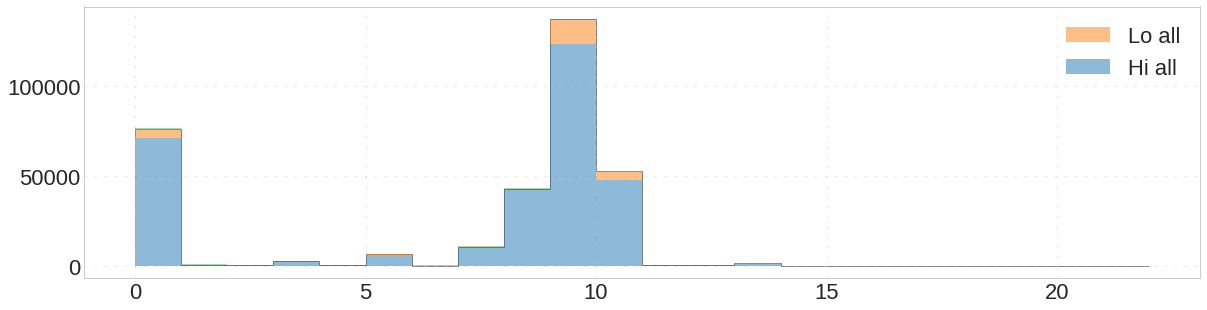

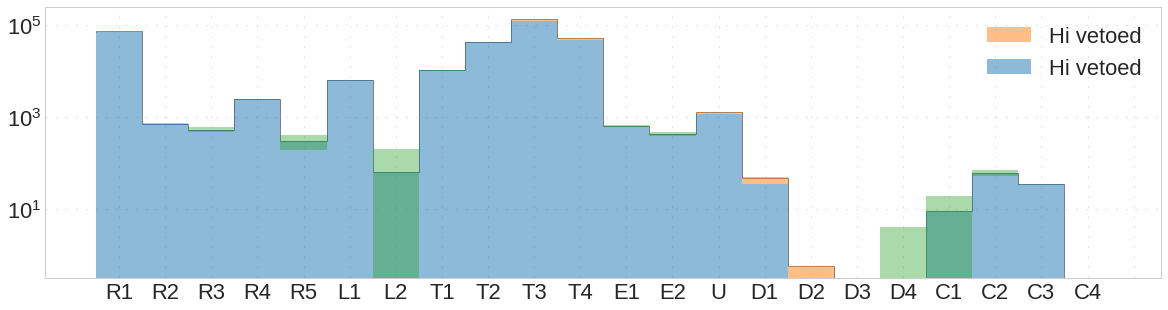

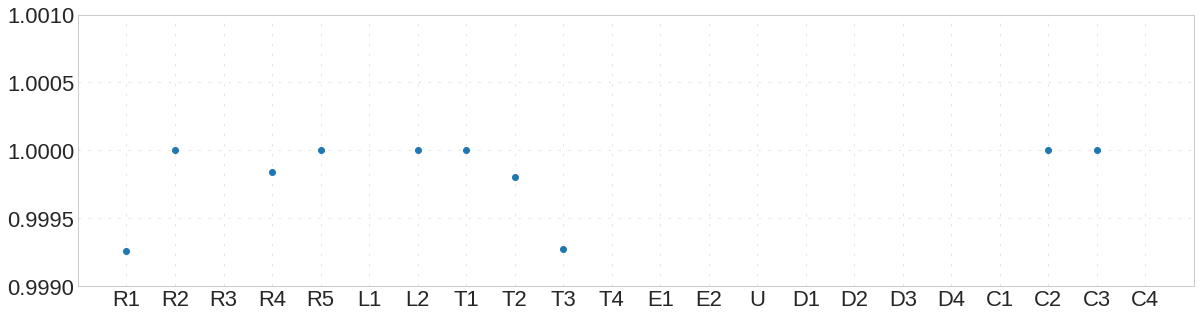

In [91]:
sectAllHi = (df.query('is_high == 1')['_crvSectorNumber']).values
sectAllLo = (df.query('is_high == 0')['_crvSectorNumber']).values
weigAllHi = MU2E_LIVETIME/HI_LIVETIME*np.ones_like(sectAllHi)
weigAllLo = MU2E_LIVETIME/LO_LIVETIME*np.ones_like(sectAllLo)

plt.rcParams['figure.figsize'] = (20,5)
stk_all = skh_plt.hist([sectAllHi, sectAllLo], histtype='barstacked',
               weights=[weigAllHi, weigAllLo], errorbars=True, bins=np.linspace(0,22,23), label=['Hi all', 'Lo all']);

plt.legend()

plt.figure()
sectVetHi = (df.query('is_high == 1 & crvinfo__timeWindowStart>0')['_crvSectorNumber']).values
sectVetLo = (df.query('is_high == 0 & crvinfo__timeWindowStart>0')['_crvSectorNumber']).values
weigVetHi = MU2E_LIVETIME/HI_LIVETIME*np.ones_like(sectVetHi)
weigVetLo = MU2E_LIVETIME/LO_LIVETIME*np.ones_like(sectVetLo)

stk_vet = skh_plt.hist([sectVetHi, sectVetLo], histtype='barstacked',
               weights=[weigVetHi, weigVetLo], errorbars=True, bins=np.linspace(0,22,23), label=['Hi vetoed', 'Hi vetoed']);

plt.legend()
plt.yscale('log')

plt.xticks(np.linspace(0.5,22.5,23), sectorNames);

plt.figure()
plt.plot(stk_vet[1][:-1], stk_vet[0][1]/stk_all[0][1], 'o')
plt.xticks(np.linspace(0.0,22.,23), sectorNames);
plt.ylim(0.999, 1.001)
#plt.yscale('log')


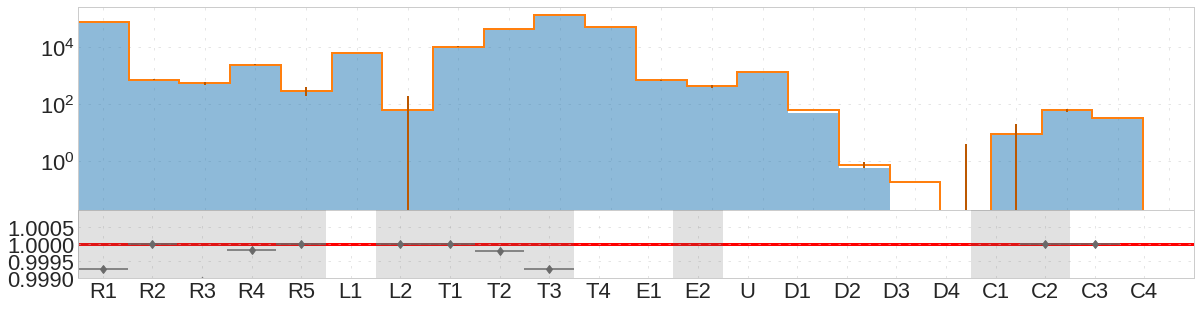

In [102]:
ratio_plot = skh_plt.ratio_plot(dict(x=np.concatenate((sectVetLo, sectVetHi)), weights=np.concatenate((weigVetLo, weigVetHi)), errorbars=False, label='Vetoed'),
                   dict(x=np.concatenate((sectAllLo,sectAllHi)), weights=np.concatenate((weigAllLo, weigAllHi)), errorbars=True, histtype='step', log=True, label='All'),
                   bins=np.linspace(0,22,23), ratio_range=(0.999, 1.001));
plt.xticks(np.linspace(0.5,22.5,23), sectorNames);